## Trying to make a better jump function with smaller HVC size, a lot of improvements and retuning required.

In [1]:
import os
import numpy as np 
import matplotlib.pyplot as plt
from numpy import core
from tqdm import tqdm
from matplotlib.colors import LinearSegmentedColormap
from functions import *
from matplotlib.textpath import TextPath
from matplotlib.patches import PathPatch

In [2]:
# running conditions
TRIALS = 1000
DAYS = 61 # 60 days of learning and 1 day of testing
N_SYLL = 1
if N_SYLL > 5 or N_SYLL < 1:
    ValueError('Invalid number of syllables')
RANDOM_SEED = 15 # SEED 3 both jump and without jump learn 
print(f'Random seed is {RANDOM_SEED}')
np.random.seed(RANDOM_SEED)

Random seed is 15


In [3]:
# modes

WEIGHT_JUMP = 2
JUMP_SLOPE = 4
JUMP_MID = 0.3

ANNEALING = 1
ANNEALING_SLOPE = 6
ANNEALING_MID = 1
HEBBIAN_LEARNING = True
LOG_NORMAL = False
balance_factor = 3
BG_influence = True

# parameters
REWARD_WINDOW = 10
BG_NOISE = 0.05

# Run paraneters
N_DISTRACTORS = 10
LEARING_RATE_RL = 0.1
LEARNING_RATE_HL = 1.5e-5 # small increase compared to CODE_8

# sigmoid layer parameters
BG_SIG_SLOPE = 2.5  # uniform output 
BG_sig_MID = 0
RA_SIG_SLOPE = 5 # most steep such that MC output is not skewed
RA_sig_MID = 0
# Sigmoid on MC is removed
# MC_SIG_SLOPE = 1 # 5 if lesser -> more difficult to climb the hill, assymptotes before 
# MC_sig_MID = 0

# layer sizes
HVC_SIZE = 10
BG_SIZE = 50
RA_SIZE = 100 
MC_SIZE = 2
N_RA_CLUSTERS = MC_SIZE
N_BG_CLUSTERS = 2

In [4]:
# Model
class NN:
    def __init__(self, hvc_size, bg_size, ra_size, mc_size):
        if LOG_NORMAL:
            self.W_hvc_bg = sym_lognormal_samples(minimum = -1, maximum = 1, size = (hvc_size, bg_size)) # changing from -1 to 1 
            self.W_hvc_ra = np.zeros((hvc_size, ra_size)) # connections start from 0 and then increase
            self.W_bg_ra = lognormal_weight((bg_size, ra_size)) # const from 0 to 1
            self.W_ra_mc = lognormal_weight((ra_size, mc_size)) # const from 0 to 1
        else:
            self.W_hvc_bg = np.random.uniform(-1,1,(hvc_size, bg_size)) # changing from -1 to 1 
            self.W_hvc_ra = np.zeros((hvc_size, ra_size)) # connections start from 0 and then increase
            self.W_bg_ra = np.random.uniform(0, 1, (bg_size, ra_size)) # const from 0 to 1
            self.W_ra_mc = np.random.uniform(0, 1, (ra_size, mc_size)) # const from 0 to 1
        # Creating channels
        # channel from ra to mc
        for i in range(N_RA_CLUSTERS):
            segPath = np.diag(np.ones(N_RA_CLUSTERS, int))[i]
            self.W_ra_mc[i*ra_size//N_RA_CLUSTERS : (i+1)*ra_size//N_RA_CLUSTERS] *= segPath
        # channel from bg to ra such that motor cortex components are independent of each other
        for i in range(N_BG_CLUSTERS):
            segPath = np.diag(np.ones(N_BG_CLUSTERS, int))[i]
            self.W_bg_ra[i*bg_size//N_BG_CLUSTERS : (i+1)*bg_size//N_BG_CLUSTERS] *= [j for j in segPath for r in range(RA_SIZE//N_BG_CLUSTERS)]

        self.hvc_size = hvc_size
        self.bg_size = bg_size
        self.ra_size = ra_size
        self.mc_size = mc_size  
        self.ra_cluster_size = ra_size // N_RA_CLUSTERS
        self.bg_cluster_size = bg_size // N_BG_CLUSTERS
        self.bg_influence = BG_influence
            
    def forward(self, hvc_array):
        self.hvc = hvc_array
        # count number of 1 in hvc, divide bg by that number
        num_ones = np.count_nonzero(hvc_array == 1)
        self.bg = new_sigmoid(np.dot(hvc_array/num_ones, self.W_hvc_bg) + np.random.normal(0, BG_NOISE, self.bg_size), m = BG_SIG_SLOPE, a = BG_sig_MID)
        self.ra = new_sigmoid(np.dot(self.bg, self.W_bg_ra/np.sum(self.W_bg_ra, axis=0)) * balance_factor * self.bg_influence + np.dot(hvc_array/num_ones, self.W_hvc_ra)* HEBBIAN_LEARNING, m = RA_SIG_SLOPE, a = RA_sig_MID) 
        self.mc = 1.5*np.dot(self.ra, self.W_ra_mc/np.sum(self.W_ra_mc, axis=0)) # outputs to +-0.50
        ''' even after BG cut off, output should remain still the same'''
        # below code is only for testing without sigmoidal functions
        # self.mc = new_sigmoid(np.dot(self.ra, self.W_ra_mc/np.sum(self.W_ra_mc, axis=0)), m = MC_SIG_SLOPE, a = MC_sig_MID)
        # self.bg = np.dot(hvc_array/num_ones, self.W_hvc_bg)  #outputs to +-0.98
        # self.ra = np.dot(self.bg, self.W_bg_ra/np.sum(self.W_bg_ra, axis=0)) * balance_factor  + np.dot(hvc_array/num_ones, self.W_hvc_ra)* HEBBIAN_LEARNING #outputs to +-0.40
        return self.mc, self.ra, self.bg

In [5]:
class Environment:
    def __init__(self, hvc_size, bg_size, ra_size, mc_size, seed):
        self.hvc_size = hvc_size
        self.bg_size = bg_size
        self.ra_size = ra_size
        self.mc_size = mc_size
        self.seed = seed
        self.model = NN(hvc_size, bg_size, ra_size, mc_size)
        # landscape parameters
        self.centers = np.random.uniform(-0.9, 0.9, (N_SYLL, 2))
        self.heights = np.random.uniform(0.2, 0.7, (N_SYLL, N_DISTRACTORS))
        self.means = np.random.uniform(-1, 1, (N_SYLL,N_DISTRACTORS, 2))
        self.spreads = np.random.uniform(0.1, 0.6, (N_SYLL, N_DISTRACTORS))
        # data storage
        self.rewards = np.zeros((DAYS, TRIALS, N_SYLL))
        self.actions = np.zeros((DAYS, TRIALS, N_SYLL, self.mc_size))
        self.hvc_bg_array = np.zeros((DAYS, TRIALS, N_SYLL))
        self.bg_out = np.zeros((DAYS, TRIALS, N_SYLL))
        self.hvc_ra_array = np.zeros((DAYS, TRIALS, N_SYLL))
        self.ra_out = np.zeros((DAYS, TRIALS, N_SYLL))
        self.RPE = np.zeros((DAYS, TRIALS, N_SYLL)) 
        self.RPE_SUM = np.zeros((DAYS, TRIALS, N_SYLL))
        self.ra_all = np.zeros((DAYS, TRIALS, N_SYLL, self.ra_size))
        self.dw_day_array = np.zeros((DAYS, N_SYLL))
        self.pot_array = np.zeros((DAYS, N_SYLL))
        self.annealing_mids = np.ones((DAYS, TRIALS, N_SYLL))*ANNEALING_MID
        self.dw_array = np.ones((DAYS*TRIALS, N_SYLL))

        
    def get_reward(self, coordinates, syll):
        # landscape creation and reward calculation
        center = self.centers[syll, :]
        reward_scape = gaussian(coordinates, 1, center, 0.3)
        if N_DISTRACTORS == 0:
            return reward_scape
        hills = []
        hills.append(reward_scape)
        for i in range(N_DISTRACTORS):
            height = self.heights[syll, i]
            mean = self.means[syll, i,:]
            spread = self.spreads[syll, i]
            hills.append(gaussian(coordinates, height, mean, spread))
        return np.maximum.reduce(hills)
     
    def run(self, learning_rate, learning_rate_hl, annealing = False):
        # modes 
        self.annealing = annealing
        self.model.bg_influence = True
        # each day, 1000 trial, n_syll syllables
        nos_iter = 0
        for day in tqdm(range(DAYS)):
            dw_day = np.zeros(N_SYLL)
            self.model.bg_influence = True
            if day >= DAYS-1: 
                self.model.bg_influence = False # BG lesion on the last day
            sum_RPE = 0
            for iter in range(TRIALS):
                for syll in range(N_SYLL):
                    # input from HVC is determined by the syllable
                    input_hvc = np.zeros(HVC_SIZE)
                    input_hvc[syll:syll+10] = 1
                    # reward, action and baseline
                    action, ra, bg = self.model.forward(input_hvc)
                    reward = self.get_reward(action, syll)
                    self.rewards[day, iter, syll] = reward
                    self.actions[day, iter, syll,:] = action
                    reward_baseline = 0
                    if iter < REWARD_WINDOW and iter > 0:
                        reward_baseline = np.mean(self.rewards[day, :iter, syll])
                    elif iter >= REWARD_WINDOW:
                        reward_baseline = np.mean(self.rewards[day, iter-REWARD_WINDOW:iter, syll])
                    # Updating weights
                    # RL update
                    dw_hvc_bg = learning_rate*(reward - reward_baseline)*input_hvc.reshape(self.hvc_size,1)*self.model.bg * self.model.bg_influence # RL update
                    self.model.W_hvc_bg += dw_hvc_bg
                    # HL update
                    dw_hvc_ra = learning_rate_hl*input_hvc.reshape(self.hvc_size,1)*self.model.ra*HEBBIAN_LEARNING # lr is supposed to be much smaller here
                    self.model.W_hvc_ra += dw_hvc_ra
                    # bound weights between +-1
                    np.core.umath.maximum(np.core.umath.minimum(self.model.W_hvc_bg, 1, out = self.model.W_hvc_bg), -1, out = self.model.W_hvc_bg) # type: ignore
                    np.core.umath.maximum(np.core.umath.minimum(self.model.W_hvc_ra, 1, out = self.model.W_hvc_ra), -1, out = self.model.W_hvc_ra) # type: ignore
                    # storing values for plotting
                    self.RPE[day, iter, syll] = reward - reward_baseline        
                    sum_RPE += reward - reward_baseline 
                    self.RPE_SUM[day, iter, syll] = sum_RPE
                    dw_day[syll] += np.mean(np.abs(dw_hvc_bg))

                    self.hvc_bg_array[day, iter, syll] = self.model.W_hvc_bg[syll,1]
                    self.bg_out[day, iter, syll] = bg[1]
                    self.hvc_ra_array[day, iter, syll] = self.model.W_hvc_ra[syll,1]
                    self.ra_out[day, iter, syll] = ra[0]
                    self.ra_all[day, iter, syll, :] = ra
                    # print(f"dw_day:{dw_day[syll]}  nos iter:{nos_iter}")

                    self.dw_array[nos_iter, syll] = dw_day[syll]
                    nos_iter += 1

            # if day % 1 == 0:   
            #     tqdm.write(f'Day: {day}, Action: {action}, Reward: {reward}, Reward Baseline: {reward_baseline}')  
            # Annealing
            if self.annealing:
                for syll in range(N_SYLL):
                    if WEIGHT_JUMP == 1:
                        ''' input daily sum, output scaling factor for potentiation'''
                        # calculating potentiation 
                        d = dw_day[syll]*100 # scaling up to be comparable
                        p = 1 * sigmoid(1*d, m = ANNEALING_SLOPE, a = ANNEALING_MID)
                        potentiation_factor = np.zeros((self.hvc_size))
                        potentiation_factor[syll] = 1-p 
                        # implementing night weight changes
                        night_noise = np.random.uniform(-1, 1, self.bg_size) # make it lognormal
                        dw_night = LEARING_RATE_RL*potentiation_factor.reshape(self.hvc_size,1)*night_noise*10*self.model.bg_influence
                        self.model.W_hvc_bg += dw_night
                        self.model.W_hvc_bg = (self.model.W_hvc_bg + 1) % 2 -1 # bound between -1 and 1 in cyclical manner
                        # storing values
                        self.pot_array[day, syll] = 1-p
                        self.dw_day_array[day, syll] = d
                    elif WEIGHT_JUMP == 2:
                        ''' input daily sum, output scaling factor for potentiation '''
                        # calculating potentiation
                        d = abs(dw_day[syll])*1 # scaling up to be comparable
                        p = 1 * sigmoid(1*d, m = ANNEALING_SLOPE, a = ANNEALING_MID)
                        potentiation_factor = np.zeros((self.hvc_size))
                        potentiation_factor[syll] = 1-p 
                        # implementing night weight changes
                        night_noise = np.random.uniform(-1, 1, self.bg_size) # make it lognormal
                        dw_night = LEARING_RATE_RL*potentiation_factor.reshape(self.hvc_size,1)*night_noise*100000*self.model.bg_influence
                        self.model.W_hvc_bg += dw_night
                        print(f"size weight:{np.mean(np.abs(self.model.W_hvc_bg))}| dw_night:{np.mean(np.abs(dw_night))}")
                        # print(np.mean(np.abs(dw_night)))
                        self.model.W_hvc_bg = (self.model.W_hvc_bg + 1) % 2 -1 # bound between -1 and 1 in cyclical manner
                        # storing values
                        self.pot_array[day, syll] = 1-p
                        self.dw_day_array[day, syll] = d
                    else:
                        # an alternate way of jumping!
                        rpe_sum_end_of_day = self.RPE_SUM[day, iter, syll]
                        potentiation_factor = 1 - sigmoid(rpe_sum_end_of_day, m = JUMP_SLOPE, a = JUMP_MID)
                        night_noise = np.random.uniform(-1, 1, (self.hvc_size, self.bg_size))   
                        dw_night = LEARING_RATE_RL*potentiation_factor*night_noise*10*self.model.bg_influence
                        self.model.W_hvc_bg += dw_night
                        self.model.W_hvc_bg = (self.model.W_hvc_bg + 1) % 2 -1 # bound between -1 and 1 in cyclical manner
                        self.pot_array[day, syll] = potentiation_factor
                
                
    def generate_trajectory(self, syll):
        x_traj, y_traj = zip(*self.actions[:,:, syll,:].reshape(-1, 2))
        limit = 1.5
        x, y = np.linspace(-limit, limit, 50), np.linspace(-limit, limit, 50)
        X, Y = np.meshgrid(x, y)
        Z = self.get_reward([X, Y], syll)
        return X,Y,Z, x_traj, y_traj, syll    
    
    def plot_trajectory(self, X, Y, Z, x_traj, y_traj, syll):
        fig, axs = plt.subplots(figsize=(10, 9))
        path = TextPath((0, 0), f'Syllable: {syll}', size=12)
        patch = PathPatch(path)
        # generate grid 
        limit = 1.5
        # Plot contour
        cmap = LinearSegmentedColormap.from_list('white_to_green', ['white', 'green'])
        contour = axs.contourf(X, Y, Z, levels=10, cmap=cmap)
        fig.colorbar(contour, ax=axs, label='Reward')
        
        # plot trajectory
        axs.plot(x_traj[::10], y_traj[::10], 'r', label='Agent Trajectory', alpha = 0.5, linewidth = 0.5) # Plot every 20th point for efficiency
        axs.scatter(x_traj[0], y_traj[0], s=20, c='b', label='Starting Point')  # Plot first point as red circle
        axs.scatter(x_traj[-5:], y_traj[-5:], s=20, c='r', marker='x', label='Ending Point') # type: ignore
        axs.scatter(self.centers[syll, 0], self.centers[syll, 1], s=20, c='y', marker='x', label='target')  # type: ignore
        # labels
        axs.set_title(f'Contour plot of reward function SEED:{RANDOM_SEED} syllable: {syll}')   
        axs.set_xlabel('x')
        axs.set_ylabel('y')
        axs.legend()
        plt.tight_layout()
        plt.show()

    def generate_results(self, syll):   
        return self.ra_all[:,:,syll,:].reshape(DAYS*TRIALS, self.ra_size)
        
    def plot_results(self, syll):
        fig, axs = plt.subplots(6, 1, figsize=(10, 15))
        axs[0].plot(self.rewards[:,:,syll].reshape(DAYS*TRIALS), '.', markersize=1, linestyle='None')
        axs[0].hlines(0.7, 0, DAYS*TRIALS, colors='r', linestyles='dashed')
        axs[0].set_ylim(0, 1)
        axs[0].set_ylabel('Reward')
        axs[1].plot(self.hvc_bg_array[:,:,syll].reshape(DAYS*TRIALS))
        axs[1].set_ylim(-1, 1)
        axs[1].set_ylabel('HVC BG weights')
        axs[2].plot(self.bg_out[:,:,syll].reshape(DAYS*TRIALS),'.', markersize=0.5, linestyle='None')
        axs[2].set_ylim(-1, 1)
        axs[2].set_ylabel('BG output')
        axs[3].plot(self.hvc_ra_array[:,:,syll].reshape(DAYS*TRIALS))
        axs[3].set_ylim(-1, 1)
        axs[3].set_ylabel('HVC RA weights')
        axs[4].plot(self.actions[:,:,syll,0].reshape(DAYS*TRIALS))
        axs[4].plot(self.actions[:,:,syll,1].reshape(DAYS*TRIALS))
        axs[4].plot(self.centers[syll, 0]*np.ones(TRIALS*DAYS))
        axs[4].plot(self.centers[syll, 1]*np.ones(TRIALS*DAYS))
        axs[4].legend(['x target', 'y target'])
        axs[4].set_ylabel('Motor Output')
        axs[4].set_ylim(-1, 1)
        axs[5].plot(self.ra_out[:,:,syll].reshape(DAYS*TRIALS))
        axs[5].set_ylim(-1, 1)
        axs[5].set_ylabel('RA activity')
        fig.suptitle('Results', fontsize=20)
        plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # type: ignore 
        plt.show()
    
    def plot_dw_day(self, syll):
        if ANNEALING:
            fig, axs = plt.subplots(4,1,figsize=(10, 15))
            expanded_dw_day_array = np.zeros((DAYS*TRIALS, N_SYLL))
            expanded_pot_array = np.zeros((DAYS*TRIALS, N_SYLL))
            # Expand dw_day_array and pot_array to match the size of rewards
            expanded_dw_day_array = np.repeat(self.dw_day_array[:, syll], DAYS*TRIALS// len(self.dw_day_array[:, syll]))
            expanded_pot_array = np.repeat(self.pot_array[:, syll], DAYS*TRIALS// len(self.pot_array[:, syll]))
            fig.suptitle(f'Annealing SEED:{RANDOM_SEED} syllable: {syll}')
            axs[0].set_title(f'Annealing SEED:{RANDOM_SEED} syllable: {syll}')  
            axs[0].plot(expanded_dw_day_array, markersize=1, label='dW_day')
            axs[0].set_ylim(0,10)
            axs[0].set_ylabel('dW_day')        
            axs[1].plot(expanded_pot_array, markersize=1, label='Potentiation factor')
            axs[1].set_ylabel('Potentiation factor')
            axs[2].plot(self.rewards[:,:,syll].reshape(DAYS*TRIALS), '.', markersize=1, label='Reward', alpha = 0.1)
            axs[2].set_ylabel('Rewards')
            axs[2].set_ylim(0, 1)
            axs[3].plot(self.RPE[:,:,syll].reshape(DAYS*TRIALS), '.', markersize=1, label='RPE', alpha = 0.1)               
            axs[3].set_ylabel('RPE')
            axs[3].set_ylim(-1, 1)
            for i in range(4):
                axs[i].vlines(range(0, DAYS*TRIALS, TRIALS), -3, 10, colors='b', linestyles='dashed')           
            plt.tight_layout()
            plt.show()

            
            # plt.plot(expanded_dw_day_array, markersize=1, label='dW_day')
            # plt.plot(expanded_pot_array, markersize=1, label='Potentiation factor')
            # plt.plot(self.rewards[:,:,syll].reshape(DAYS*TRIALS), '.', markersize=1, label='Reward', alpha = 0.1)
            # plt.xlabel('Days')
            # plt.ylabel('dW_day')
            # plt.legend()
            # plt.show()  
        
    def save_trajectory(self, syll):
        fig, axs = plt.subplots(figsize=(10, 9))
        # generate grid 
        x, y = np.linspace(-1, 1, 50), np.linspace(-1, 1, 50)
        X, Y = np.meshgrid(x, y)
        Z = self.get_reward([X, Y], syll)
        # Plot contour
        cmap = LinearSegmentedColormap.from_list('white_to_green', ['white', 'green'])
        contour = axs.contourf(X, Y, Z, levels=10, cmap=cmap)
        fig.colorbar(contour, ax=axs, label='Reward')
        
        # plot trajectory
        x_traj, y_traj = zip(*self.actions[:,:, syll,:].reshape(-1, 2))
        axs.plot(x_traj[::10], y_traj[::10], 'r', label='Agent Trajectory', alpha = 0.5, linewidth = 0.5) # Plot every 20th point for efficiency
        axs.scatter(x_traj[0], y_traj[0], s=20, c='b', label='Starting Point')  # Plot first point as red circle
        axs.scatter(x_traj[-5:], y_traj[-5:], s=20, c='r', marker='x', label='Ending Point') # type: ignore
        axs.scatter(self.centers[syll, 0], self.centers[syll, 1], s=20, c='y', marker='x', label='target')  # type: ignore
        # labels
        axs.set_title(f'Contour plot of reward function SEED:{RANDOM_SEED} syllable: {syll}')
        axs.set_xlabel('x')
        axs.set_ylabel('y')
        axs.legend()
        plt.tight_layout()
        # Create the "plots" directory if it doesn't exist
        os.makedirs(save_dir, exist_ok = True)
        # Clear previous plots (optional):
        # for filename in os.listdir(save_dir):
        #     if filename.startswith("trajectory") and filename.endswith(".png") or filename.endswith(".jpg"):
        #         os.remove(os.path.join(save_dir, filename))
        # Save the plot
        plt.savefig(os.path.join(save_dir, f"trajectory_{RANDOM_SEED}_{syll}.png"))
        plt.close()  # Close the plot to avoid memory leaks
        
    def save_results(self, syll):
        fig, axs = plt.subplots(6, 1, figsize=(10, 15))
        axs[0].plot(self.rewards[:,:,syll].reshape(DAYS*TRIALS), '.', markersize=1, linestyle='None')
        axs[0].hlines(0.7, 0, DAYS*TRIALS, colors='r', linestyles='dashed')
        axs[0].set_ylim(0, 1)
        axs[0].set_ylabel('Reward')
        axs[1].plot(self.hvc_bg_array[:,:,syll].reshape(DAYS*TRIALS))
        axs[1].set_ylim(-1, 1)
        axs[1].set_ylabel('HVC BG weights')
        axs[2].plot(self.bg_out[:,:,syll].reshape(DAYS*TRIALS),'.', markersize=0.5, linestyle='None')
        axs[2].set_ylim(-1, 1)
        axs[2].set_ylabel('BG output')
        axs[3].plot(self.hvc_ra_array[:,:,syll].reshape(DAYS*TRIALS))
        axs[3].set_ylim(-1, 1)
        axs[3].set_ylabel('HVC RA weights')
        axs[4].plot(self.actions[:,:,syll,0].reshape(DAYS*TRIALS))
        axs[4].plot(self.actions[:,:,syll,1].reshape(DAYS*TRIALS))
        axs[4].plot(self.centers[syll, 0]*np.ones(TRIALS*DAYS))
        axs[4].plot(self.centers[syll, 1]*np.ones(TRIALS*DAYS))
        axs[4].legend(['x target', 'y target'])
        axs[4].set_ylabel('Motor Output')
        axs[4].set_ylim(-1, 1)
        axs[5].plot(self.ra_out[:,:,syll].reshape(DAYS*TRIALS))
        axs[5].set_ylim(-1, 1)
        axs[5].set_ylabel('RA activity')
        fig.suptitle(f'Results SEED:{RANDOM_SEED} syllable: {syll}', fontsize=20)
        plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # type: ignore 
        # Create the "plots" directory if it doesn't exist
        os.makedirs(save_dir, exist_ok = True)
        # Clear previous plots (optional):
        # for filename in os.listdir(save_dir):
        #     if filename.startswith("results") and filename.endswith(".png") or filename.endswith(".jpg"):
        #         os.remove(os.path.join(save_dir, filename))
        # Save the plot
        plt.savefig(os.path.join(save_dir, f"results_{RANDOM_SEED}_{syll}.png"))
        plt.close()  # Close the plot to avoid memory leaks
        
    def save_dw_day(self, syll):
        if ANNEALING:
            expanded_dw_day_array = np.zeros((DAYS*TRIALS, N_SYLL))
            expanded_pot_array = np.zeros((DAYS*TRIALS, N_SYLL))
            # Expand dw_day_array and pot_array to match the size of rewards
            expanded_dw_day_array = np.repeat(self.dw_day_array[:, syll], DAYS*TRIALS// len(self.dw_day_array[:, syll]))
            expanded_pot_array = np.repeat(self.pot_array[:, syll], DAYS*TRIALS// len(self.pot_array[:, syll]))
            plt.title(f'Annealing SEED:{RANDOM_SEED} syllable: {syll}')
            plt.plot(expanded_dw_day_array, markersize=1, label='dW_day')
            plt.plot(expanded_pot_array, markersize=1, label='Potentiation factor')
            plt.plot(self.rewards[:,:,syll].reshape(DAYS*TRIALS), '.', markersize=1, label='Reward', alpha = 0.1)
            plt.xlabel('Days')
            plt.ylabel('dW_day')
            plt.legend()
            # Create the "plots" directory if it doesn't exist
            os.makedirs(save_dir, exist_ok = True)
            # # Clear previous plots (optional):
            # for filename in os.listdir(save_dir):
            #     if filename.startswith("dw") and filename.endswith(".png") or filename.endswith(".jpg"):
            #         os.remove(os.path.join(save_dir, filename))
            # Save the plot
            plt.savefig(os.path.join(save_dir, f"dw_{RANDOM_SEED}_{syll}.png"))
            plt.close()  # Close the plot to avoid memory leaks         
    

In [6]:
env = Environment(HVC_SIZE, BG_SIZE, RA_SIZE, MC_SIZE, RANDOM_SEED)
env.run(LEARING_RATE_RL, LEARNING_RATE_HL, ANNEALING) # type: ignore 
# remove_prev_files()
for i in range(N_SYLL):
    X, Y, Z, x_traj, y_traj, syll = env.generate_trajectory(i)



  3%|▎         | 2/61 [00:00<00:03, 17.25it/s]

size weight:0.6785253800047361| dw_night:0.20820203183241515
size weight:0.5637078675861228| dw_night:0.07662267984409189


  7%|▋         | 4/61 [00:00<00:03, 17.33it/s]

size weight:0.580110426188118| dw_night:0.09303846909991849
size weight:0.6704310055513162| dw_night:0.17864186816261765


 10%|▉         | 6/61 [00:00<00:03, 17.37it/s]

size weight:0.5384707419676658| dw_night:0.009669254149793301
size weight:0.5415971504345259| dw_night:0.048018078147271055


 13%|█▎        | 8/61 [00:00<00:03, 17.36it/s]

size weight:0.5414033318827467| dw_night:0.0260832490505745
size weight:0.5557760010010129| dw_night:0.019843057188673057


 16%|█▋        | 10/61 [00:00<00:02, 17.41it/s]

size weight:0.6269953689051316| dw_night:0.1064723297324526
size weight:0.5749322651398561| dw_night:0.014970743534273533


 20%|█▉        | 12/61 [00:00<00:02, 17.45it/s]

size weight:0.5880726826570085| dw_night:0.02776381276225135
size weight:0.6253976705474488| dw_night:0.06970371357548441


 23%|██▎       | 14/61 [00:00<00:02, 17.48it/s]

size weight:0.6062009419036396| dw_night:0.0019192913258233568
size weight:0.7149349261554525| dw_night:0.15100620076904728


 26%|██▌       | 16/61 [00:00<00:02, 17.47it/s]

size weight:0.7153189967339494| dw_night:0.1331496582551562
size weight:0.7389013942101363| dw_night:0.14266494330007407


 30%|██▉       | 18/61 [00:01<00:02, 17.45it/s]

size weight:0.768707121779978| dw_night:0.14175544490380843
size weight:0.7035649318481598| dw_night:0.05603351085970081


 33%|███▎      | 20/61 [00:01<00:02, 17.48it/s]

size weight:1.0196207242488902| dw_night:0.3792339258821098
size weight:0.9920063445026001| dw_night:0.32953868934337216


 36%|███▌      | 22/61 [00:01<00:02, 17.46it/s]

size weight:3.752069450207735| dw_night:3.0714607841200285
size weight:18.788356104008592| dw_night:18.101316339856638


 39%|███▉      | 24/61 [00:01<00:02, 17.43it/s]

size weight:7.777495260345914| dw_night:7.066940766105787
size weight:52.70495899016295| dw_night:51.99478723035952


 43%|████▎     | 26/61 [00:01<00:02, 17.44it/s]

size weight:1.4469391338333781| dw_night:0.7168742693425747
size weight:9.322374526044968| dw_night:8.585242038041903


 46%|████▌     | 28/61 [00:01<00:01, 17.44it/s]

size weight:24.28392710266807| dw_night:23.51600259628959
size weight:2.1265919737490413| dw_night:1.3648984287941621


 49%|████▉     | 30/61 [00:01<00:01, 17.43it/s]

size weight:3.903976139905301| dw_night:3.1311320507196543
size weight:132.27036176200662| dw_night:131.48022434177994


 52%|█████▏    | 32/61 [00:01<00:01, 17.49it/s]

size weight:17.085681933015163| dw_night:16.27329581858543
size weight:100.31320108065181| dw_night:99.50411715059526


 56%|█████▌    | 34/61 [00:01<00:01, 17.43it/s]

size weight:4.139189454692546| dw_night:3.315253420507931
size weight:49.44867163153629| dw_night:48.622601223052726


 59%|█████▉    | 36/61 [00:02<00:01, 17.36it/s]

size weight:19.578945768424934| dw_night:18.736098376173057
size weight:66.4544649346146| dw_night:65.62252647166254


 62%|██████▏   | 38/61 [00:02<00:01, 17.37it/s]

size weight:43.85788858918904| dw_night:43.02155755310186
size weight:361.51771043410804| dw_night:360.6763703049297


 66%|██████▌   | 40/61 [00:02<00:01, 17.40it/s]

size weight:440.9845399964994| dw_night:440.1433923013609
size weight:5.8808604562719395| dw_night:5.0281235565915985


 69%|██████▉   | 42/61 [00:02<00:01, 17.39it/s]

size weight:504.2831439887491| dw_night:503.416173338713
size weight:261.313766119126| dw_night:260.45987994667746


 72%|███████▏  | 44/61 [00:02<00:00, 17.41it/s]

size weight:372.2465250491416| dw_night:371.39594351119365
size weight:86.48470665589537| dw_night:85.62877585108747


 75%|███████▌  | 46/61 [00:02<00:00, 17.40it/s]

size weight:63.43615693371875| dw_night:62.55973240226604
size weight:104.7154395551212| dw_night:103.84197603137558


 79%|███████▊  | 48/61 [00:02<00:00, 17.40it/s]

size weight:25.955937368619356| dw_night:25.098848205513924
size weight:9.80342299542524| dw_night:8.931084044254327


 82%|████████▏ | 50/61 [00:02<00:00, 17.47it/s]

size weight:25.73566046426051| dw_night:24.87997520755196
size weight:352.2314450930344| dw_night:351.3630398345869


 85%|████████▌ | 52/61 [00:02<00:00, 17.41it/s]

size weight:17.212146136220923| dw_night:16.326517247553554
size weight:26.22105007675805| dw_night:25.353448788849725


 89%|████████▊ | 54/61 [00:03<00:00, 17.45it/s]

size weight:118.37386573939948| dw_night:117.51273500828125
size weight:50.39190005409406| dw_night:49.52024105466594


 92%|█████████▏| 56/61 [00:03<00:00, 17.45it/s]

size weight:48.60797652522912| dw_night:47.74442367682431
size weight:68.70880806232383| dw_night:67.8397785909286


 95%|█████████▌| 58/61 [00:03<00:00, 17.43it/s]

size weight:28.777254381736054| dw_night:27.911629537686853
size weight:63.45370253822057| dw_night:62.56831704439948


 98%|█████████▊| 60/61 [00:03<00:00, 17.46it/s]

size weight:370.0992168771851| dw_night:369.2286523161712
size weight:421.14603098626105| dw_night:420.2693481816272


100%|██████████| 61/61 [00:03<00:00, 17.43it/s]

size weight:0.922883697220563| dw_night:0.0


In [7]:
def plot_trajectory(X, Y, Z, x_traj, y_traj, syll):
    fig, axs = plt.subplots(figsize=(10, 9))
    limit = 1.5
    cmap = LinearSegmentedColormap.from_list('white_to_green', ['white', 'black'])
    contour = axs.contourf(X, Y, Z, levels=10, cmap=cmap)
    fig.colorbar(contour, ax=axs, label='Reward')
    # plot trajectory
    axs.plot(x_traj[::10], y_traj[::10], 'yellow', label='Agent Trajectory', alpha = 0.3, marker = ".", linewidth = 0.2, markersize = 0.99) # Plot every 20th point for efficiency
    axs.scatter(x_traj[0], y_traj[0], s=100, c='blue', label='Starting Point', marker = 'x')  # type: ignore # Plot first point as red circle
    axs.scatter(x_traj[-1001], y_traj[-1001], s=100, c='pink', marker='x', label='Before Lesion Ending Point')
    axs.scatter(x_traj[-5:], y_traj[-5:], s=100, c='r', marker='x', label='After Leison Point') # type: ignore
    axs.scatter(env.centers[syll, 0], env.centers[syll, 1], s=100, c='green', marker='x', label='target')  # type: ignore
    # labels
    axs.set_title(f'Contour plot of reward function SEED:{RANDOM_SEED} syllable: {syll}')
    axs.set_ylabel(r'$P_{\alpha}$')
    axs.set_xlabel(r'$P_{\beta}$')
    axs.legend()
    plt.tight_layout()
    plt.show()

expanded_dw_day = np.zeros((DAYS*TRIALS))
def plot_dw_day(syll):
    if ANNEALING:
        fig, axs = plt.subplots(5,1,figsize=(6, 10))
        expanded_dw_day_array = np.zeros((DAYS*TRIALS, N_SYLL))
        expanded_pot_array = np.zeros((DAYS*TRIALS, N_SYLL))
        # Expand dw_day_array and pot_array to match the size of rewards
        expanded_dw_day_array = np.repeat(env.dw_day_array[:, syll], DAYS*TRIALS// len(env.dw_day_array[:, syll]))
        expanded_dw_day = expanded_dw_day_array.reshape(DAYS*TRIALS)
        expanded_pot_array = np.repeat(env.pot_array[:, syll], DAYS*TRIALS// len(env.pot_array[:, syll]))
        fig.suptitle(f'Annealing SEED:{RANDOM_SEED} syllable: {syll}')
        axs[0].plot(expanded_dw_day_array, markersize=1, label='dW_day')
        axs[0].plot(env.annealing_mids[:,:,syll].reshape(DAYS*TRIALS))
        axs[0].set_ylabel('dW_day = mean(abs(dw_hvc_bg))')         
        axs[0].set_ylim(0,5) 
        axs[1].plot(expanded_pot_array, markersize=1, label='Potentiation factor')
        axs[1].set_ylabel('Size of night jump')
        axs[1].set_ylim(0, 1)
        axs[2].plot(env.rewards[:,:,syll].reshape(DAYS*TRIALS), '.', markersize=1, label='Reward', alpha = 0.1)
        axs[2].set_ylabel('Rewards')
        axs[2].set_ylim(0, 1)
        axs[3].plot(env.RPE[:,:,syll].reshape(DAYS*TRIALS), '.', markersize=1, label='RPE', alpha = 0.1)               
        axs[3].set_ylabel('RPE')
        axs[3].set_ylim(-1, 1)
        axs[4].plot(env.RPE_SUM[:,:,syll].reshape(DAYS*TRIALS), '.', markersize=1, label='RPE_SUM', alpha = 0.1)
        axs[4].set_ylabel('RPE sum for a day')
        axs[4].hlines(JUMP_MID, 0, DAYS*TRIALS, color = "red")
        axs[4].set_ylim(-1, 4)    
        for i in range(5):
            axs[i].vlines(range(0, DAYS*TRIALS, TRIALS), -3, 10, colors='black', linestyles='dashed', alpha = 0.1)           
        plt.tight_layout()
        plt.show()


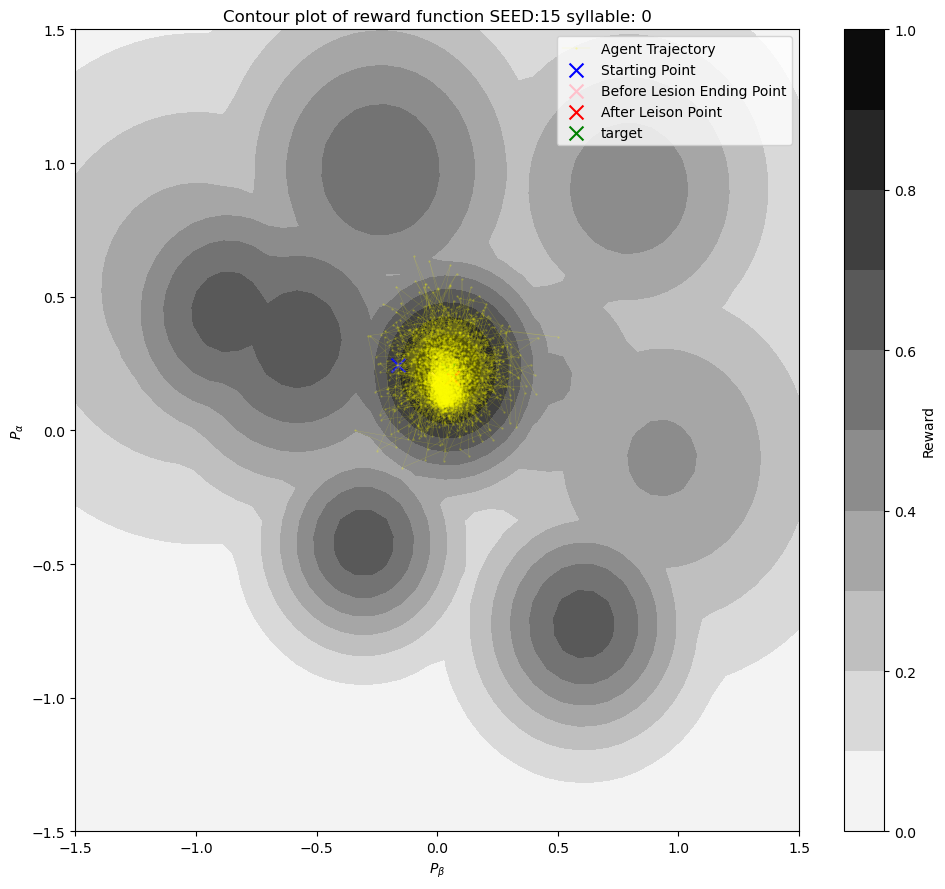

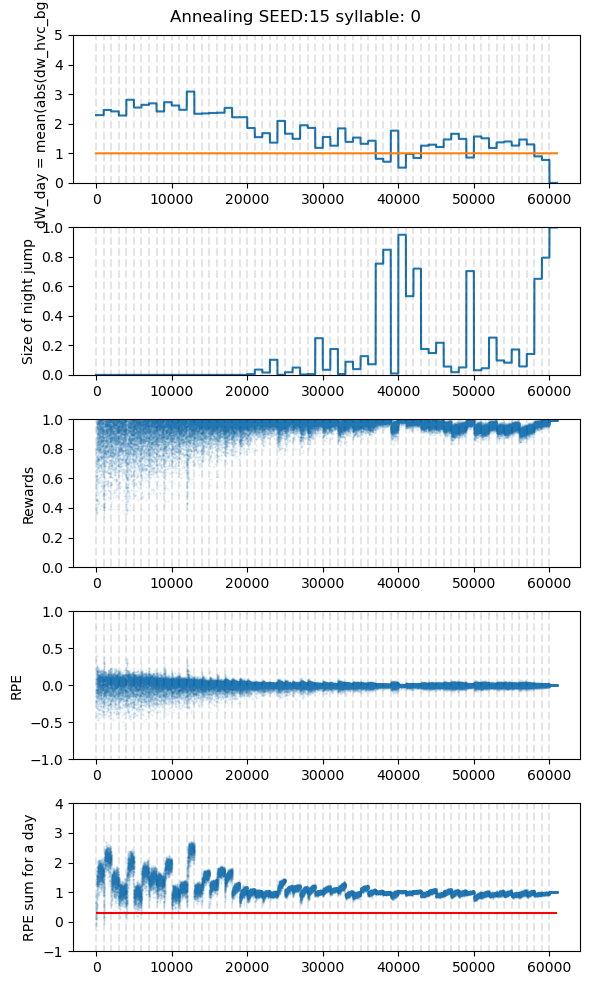

(61000,)
(61000,)
Correlations
nan
Correlation between Reward and sum RPE: -0.07305112572277166


/home/atharvsagar/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/atharvsagar/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


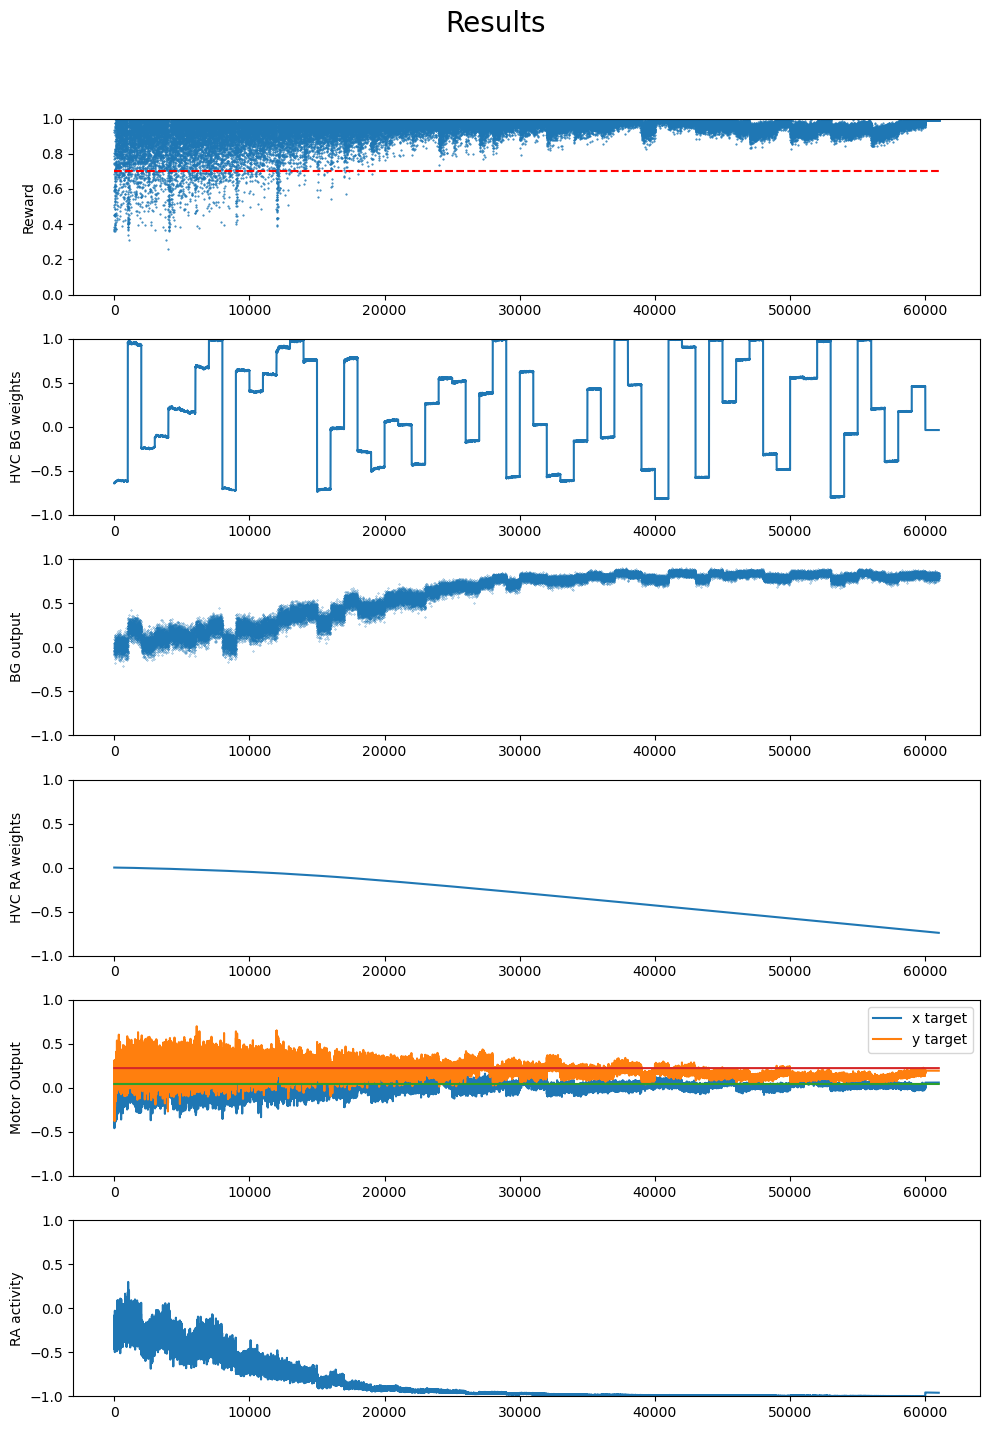

In [8]:
plot_trajectory(X, Y, Z, x_traj, y_traj, syll) 
plot_dw_day(0)
print(expanded_dw_day.reshape(DAYS*TRIALS).shape)
print(env.rewards[:,:,syll].reshape(DAYS*TRIALS).shape)
print("Correlations")
print(np.corrcoef(env.rewards[:,:,0].reshape(DAYS*TRIALS), expanded_dw_day)[0,1])    
print(f"Correlation between Reward and sum RPE: {np.corrcoef(env.rewards[:,:,0].reshape(DAYS*TRIALS), env.RPE_SUM[:,:,0].reshape(DAYS*TRIALS))[0,1]}")                   
ra_all = env.generate_results(i)
env.plot_results(i)


# def build_and_run(seed, annealing, plot):
#     tqdm.write(f" Random seed is {seed}")
#     np.random.seed(seed)
#     env = Environment(HVC_SIZE, BG_SIZE, RA_SIZE, MC_SIZE, RANDOM_SEED)
#     env.run(LEARING_RATE_RL, LEARNING_RATE_HL, ANNEALING)
#     remove_prev_files()
#     for i in range(N_SYLL):
#         env.save_trajectory(i)
#         env.save_results(i)
#         if ANNEALING:
#             env.save_dw_day(i)
#     return np.mean(env.rewards[:,-100:], axis=1)

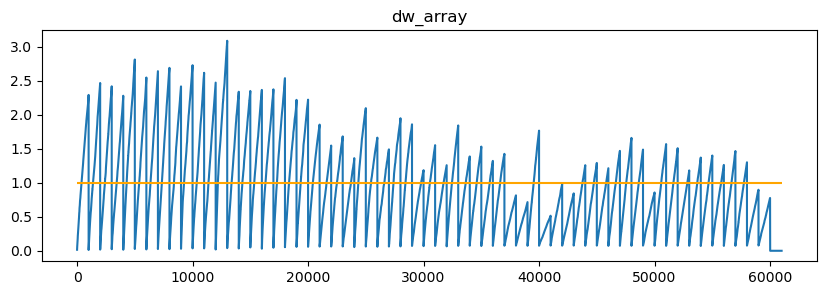

In [9]:
plt.figure(figsize=(10,3))
plt.plot(env.dw_array[:,0])
plt.hlines(ANNEALING_MID, 0,TRIALS*DAYS, colors="orange")
plt.title("dw_array")
plt.show()

In [10]:
print(env.rewards[(DAYS-1)*TRIALS-100:(DAYS-1)*TRIALS])
rewards = env.rewards[:,:,0].reshape(DAYS*TRIALS)
np.mean(rewards[(DAYS-1)*TRIALS-100:(DAYS-1)*TRIALS])
print(np.mean(rewards[(DAYS-1)*TRIALS-100:(DAYS-1)*TRIALS]))
print(np.mean(rewards[(DAYS)*TRIALS-100:(DAYS)*TRIALS]))        

[]
0.9782897509904599
0.9937411844276108
